# TP 4 - Approximate Nearest Neighbours

### OHSUMED Loading

In [200]:
import matplotlib.pyplot as plot
import mmh3
import os
import random
import re
import sys

In [201]:
ROOT_DIR = 'ohsumed-first-20000-docs'

def load(folder_path, nb_files):
    loaded = []
    for root, subFolders, files in os.walk(folder_path):
        for f in files:
            if nb_files == 0:
                return loaded
            path = os.path.join(root, f)
            with open(path, "r") as doc:
                loaded.append(doc.read())
            nb_files = nb_files - 1
    return loaded

raw_documents = load(ROOT_DIR, 1000)

### Convert document to pseudo one-hot

In [202]:
def process_documents(documents):
    """Converts a document to a set structure.
    
    This will allows to easily perform set operations,
    such as intersection or union.
    
    """
    
    processed = []
    for doc in documents:
        # We split the doc on any english separator
        split = re.split("[.,; ><()\t\n\!?:]+", doc)
        # We filtered anything that is not a correct word. e.g: "àà&à&é".
        filtered = list(filter(
            lambda x: not(re.search('[a-zA-Z0-9]', x) is None),
            split
        ))
        # Creates a set from the filtered list.
        processed.append(set(filtered))
    
    return processed

In [203]:
documents = process_documents(raw_documents)

### KKN functions

The functions below can be used with Jaccard or MinHash, by juste passing the reference to the function.

In [148]:
def knn_basic(k, doc_id, documents, dist_func):
        """Returns the `k' nearest neighbours of a given
        document id, in a given documents list.
        
        This function makes pair-wise test, it can be heavy.
        
        This function can be used with MinHash dist, or Jaccard dist.
        
        """
        
        nb_docs = len(documents)
        target_doc = documents[doc_id]
        # In order to reduce memory usage, we will not
        # keep **every** distance and sort them before returning
        # the result. We will only store the knn directly and
        # keep the result sorted.
        # The tuple contains (distance, doc_id)
        knn = [[1.1, -1] for i in range(0, k)]
        for i in range(0, nb_docs):
            # We make sure we do not take our doc
            # into account when applying knn.
            if not(doc_id == i):
                dist = dist_func(target_doc, documents[i])
                if dist < knn[k - 1][0]:
                    knn[k - 1][0] = dist
                    knn[k - 1][1] = i
                    knn = sorted(knn)
                  
        # Extracts only document id
        result = []
        for i in range(0, k):
            result.append(knn[i][1])
        return result

## Jaccard

In [149]:
class Jaccard:
    @staticmethod
    def distance(doc1, doc2):
        """Computes the Jaccard distance of two documents.

        """
        
        intersection_size = len(set.intersection(doc1, doc2))
        union_size = len(set.union(doc1, doc2))
        return 1.0 - (intersection_size / union_size)

##### Test with two documents

In [150]:
nb_documents = len(documents)
doc1 = documents[random.randint(0, nb_documents)]
doc2 = documents[random.randint(0, nb_documents)]
print('Test with two random documents:')
print('Jaccard distance: {}'.format(Jaccard.distance(doc1, doc2)))
print()
print('Test with twice the same document:')
print('Jaccard distance: {}'.format(Jaccard.distance(doc1, doc1)))

Test with two random documents:
Jaccard distance: 0.9482758620689655

Test with twice the same document:
Jaccard distance: 0.0


## MinHash

In [198]:
class MinHash:
    @staticmethod
    def convert(doc, nb_hash):
        """Computes the min hashing of a single document.

        """
        
        # The __hash_factor is used just to provide a little
        # more randomness to the hash seeds
        hash_factor = random.randint(0, 1000)
        
        min_hash = [sys.maxsize for i in range(0, nb_hash)]
        for word in doc:
            for i in range(0, nb_hash):
                seed = i * 1000
                hash_val = mmh3.hash(word, seed)
                min_hash[i] = min(min_hash[i], hash_val)
                
        return min_hash
    
    def distance(doc1_hash, doc2_hash):
        """Computes the distance between two MinHash

        """
        
        if len(doc1_hash) != len(doc2_hash):
            raise ValueError('Doc1 and Doc2 should have an equal MinHash size.')
        
        dist = 0
        for i in range(0, len(doc1_hash)):
            dist = dist + 1 if doc1_hash[i] == doc2_hash[i] else dist
            
        # We take the opposite probability in order to have
        # the same kind of probabilty that Jaccard output.
        return 1.0 - (dist / len(doc1_hash))
    
    def convert_and_dist(nb_hash, doc1, doc2):
        """ This function is just a wrapper calling `convert'
        and `distance'.
        
        """
        doc1_hash = MinHash.convert(doc1, nb_hash)
        doc2_hash = MinHash.convert(doc2, nb_hash)
        
        return MinHash.distance(doc1_hash, doc2_hash)

#### Test with two documents

In [199]:
doc1 = documents[random.randint(0, nb_documents)]
doc2 = documents[random.randint(0, nb_documents)]

min_hash1 = MinHash.convert(doc1, 100)
min_hash2 = MinHash.convert(doc2, 100)

print('Test with two random documents:')
print('Min hash distance: {}'.format(MinHash.distance(min_hash1, min_hash2)))
print()
print('Test with twice the same document:')
print('Min hash distance: {}'.format(MinHash.distance(min_hash2, min_hash2)))

Test with two random documents:
Min hash distance: 0.86

Test with twice the same document:
Min hash distance: 0.0


### Test both distance with same documents

In [189]:
doc1 = documents[random.randint(0, nb_documents - 1)]
doc2 = documents[random.randint(0, nb_documents - 1)]

min_hash1 = MinHash.convert(doc1, 50)
min_hash2 = MinHash.convert(doc2, 50)

print('Jaccard distance: {}'.format(Jaccard.distance(doc1, doc2)))
print()
print('MinHash distance: {}'.format(MinHash.distance(min_hash1, min_hash2)))

Jaccard distance: 0.9121621621621622

MinHash distance: 0.9


### KNN function with Jaccard distance

In [194]:
# We will test the KNN with the same target document,
# in order to be sure that it works correctly.
target_doc_id = random.randint(0, nb_documents)

In [195]:
print('10 nearest document id\'s:')
knn_basic(10, target_doc_id, documents, Jaccard.distance)

10 nearest document id's:


[5, 4, 20, 47, 57, 75, 6, 21, 97, 18]

### KNNMinHash

In [197]:
# Bind the number of hash function is order to use the knn_basic function
# more easily. If we do not make this, we canno't use the knn_basic function,
# because we will call the MinHash.convert_and_dist with an argument missing.

def minhash_dist_bind(doc1, doc2):
    return MinHash.convert_and_dist(50, doc1, doc2)

print('10 nearest document id\'s:')
knn_basic(10, target_doc_id, documents, minhash_dist_bind)

10 nearest document id's:


[5, 75, 97, 26, 30, 47, 2, 20, 57, 74]

## Jaccard VS MinHash

In [220]:
def profile(n_batch, k_batch, doc_batch, title):
    
    plot.title(title)
    plot.xlabel('Number `k\' of neighbours for the KNN')
    plot.ylabel('% error between Jaccard and MinHash')
    
    nb_docs = len(doc_batch)
    
    def nb_similar(list_a, list_b):
        return len(set.intersection(set(list_a), set(list_b)))
    
    # Computes Jaccard first, as we do not need
    # To loop over `n_batch' for this one.
    jaccard_distances = []
    for i in range(0, nb_docs):
        distances = []
        for k in k_batch:
            distances.append(
                knn_basic(k, i, doc_batch, Jaccard.distance)
            )
        jaccard_distances.append(distances)
    
    # Computes MinHash and plot similarity with Jaccard
    for n in n_batch:
        def minhash_dist(doc1, doc2):
            return MinHash.convert_and_dist(n, doc1, doc2)
        similitudes = []
        for k_idx in range(0, len(k_batch)):
            k = k_batch[k_idx]
            similitude = 0
            for i in range(0, nb_docs):
                knn = knn_basic(k, i, doc_batch, minhash_dist)
                similitude = similitude + nb_similar(knn, jaccard_distances[i][k_idx])
            similitudes.append(similitude / (k * (nb_docs - 1)))
        plot.plot(k_batch, similitudes, label='n={}'.format(n))    
    
    plot.legend(loc='upper right')
    plot.show()

### MinHash BruteForce vs Jaccard

In [223]:
rand_ids = random.sample(range(0, nb_documents), 50)
docs_50 = [documents[i] for i in rand_ids]

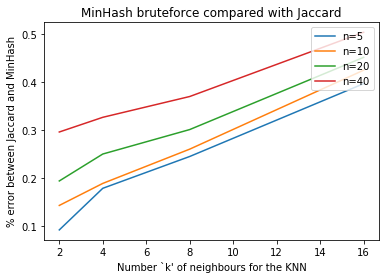

In [224]:
profile([5, 10, 20, 40], [2, 4, 8, 16], docs_50, 'MinHash bruteforce compared with Jaccard')